# Market Data

The trade data for this project is acquired from [Poloniex](https://poloniex.com) exchange, which is the number 1 crypto currency exchange by [daily volume](http://coinmarketcap.com/exchanges/volume/24-hour/). 

From Poloniex we are able to acquire [historical trade data](#Historical-Trade-Data), real-time orderbook data and real-time trollbox data. We start by acquiring the historical trade data and standardizing our samples across markets. We also acquire the real-time data and save it for incorporation in the training model. 

In [244]:
import os
import json
import time
import requests
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

from IPython.core.display import HTML
HTML('<style>{}</style>'.format( open('style.css').read() ) )

In [5]:
import sys 
sys.version_info #__version__

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

** Create function for requesting Poloniex data **

In [6]:
def poloniex_api(command, args={}):
    url = 'https://poloniex.com/public?command='+command
    for arg, value in args.items():
        url += '&{}={}'.format(arg,value)
    return json.loads(requests.get(url).content.decode('utf-8'))

## Historical Trade Data
The trade data wrangling process requires that we group and standardize the time series data according to time interval. We then group our sample populations by trade type(i.e. buy or sell) and volume level (e.g. high). 



#### Top markets by daily trade volume
First, lets get the markets with the highest daily volume. To keep things simple we only look at BTC denominated markets.

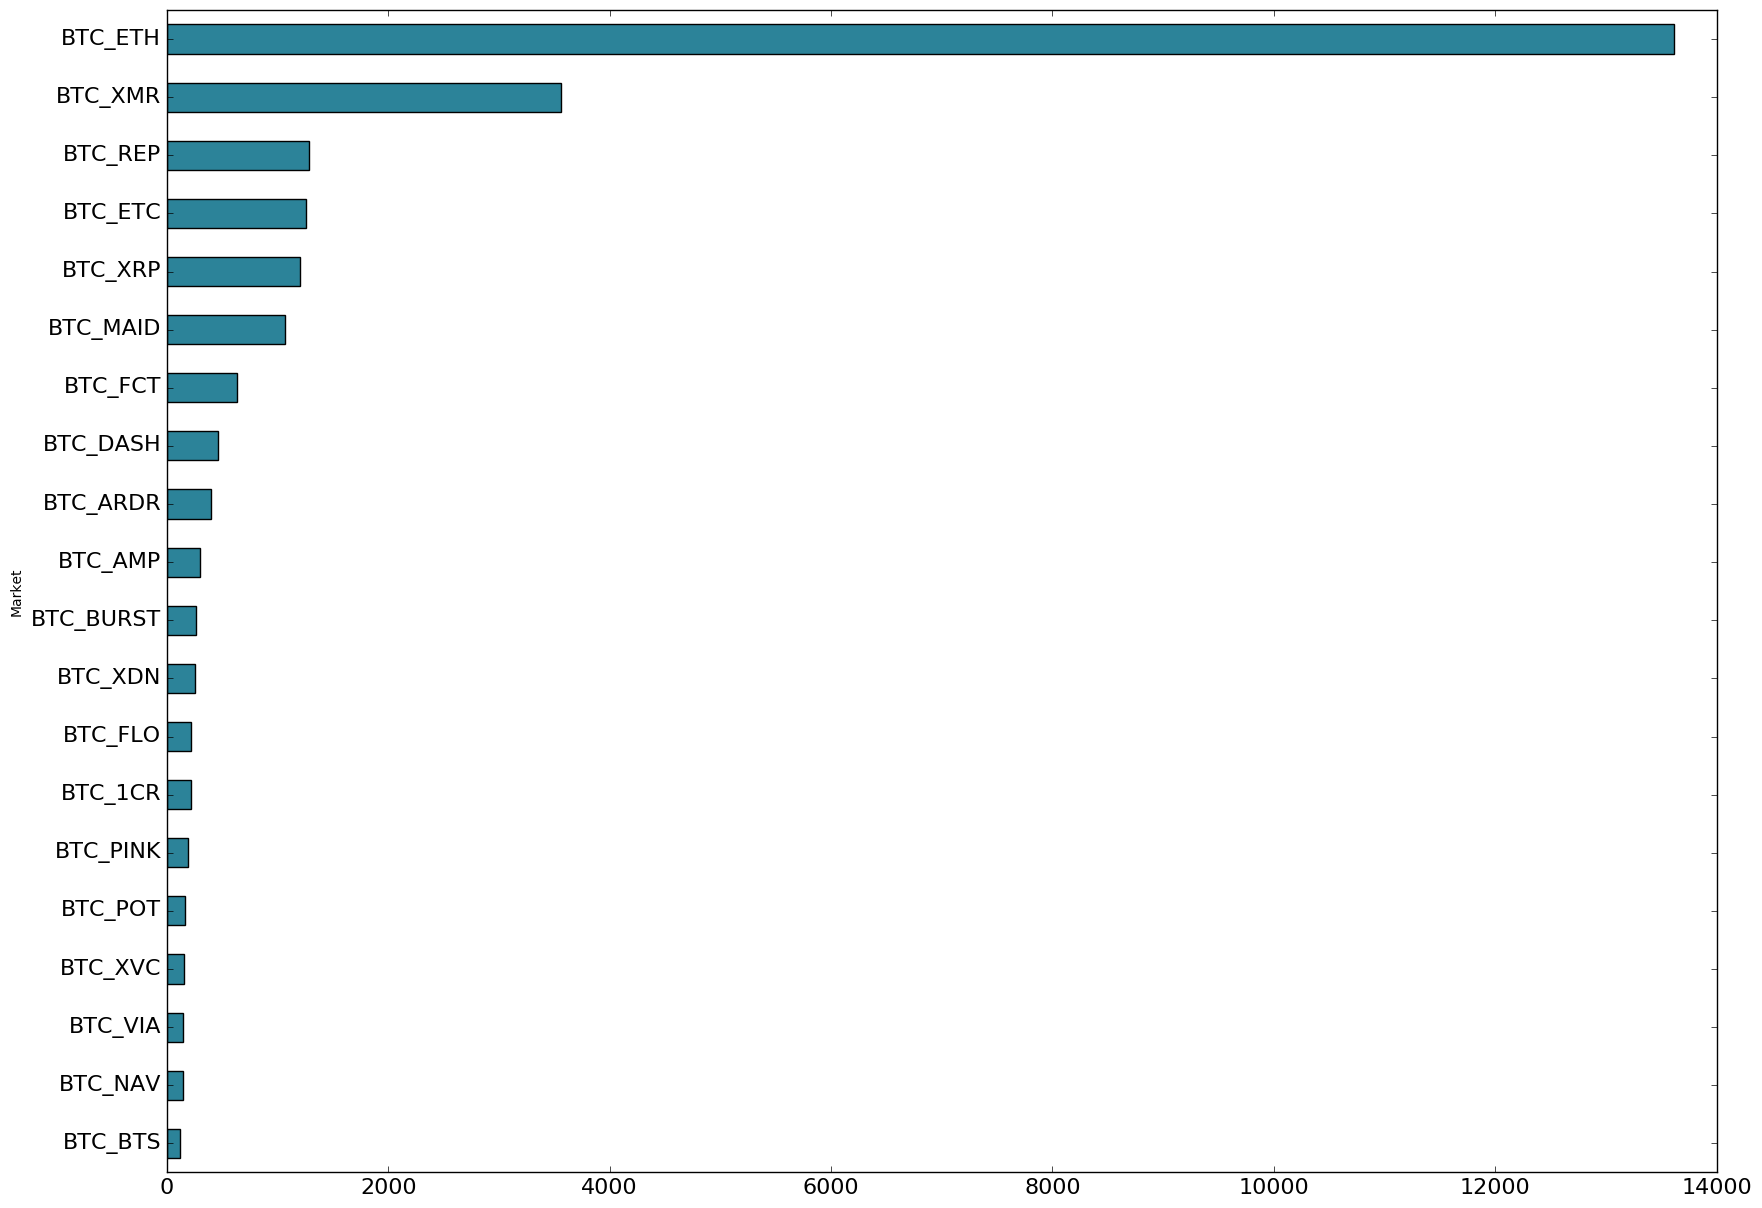

In [7]:
market_volumes = poloniex_api('return24hVolume')
btc_market_volumes = [(m, float(market_volumes[m]['BTC'])) for m in market_volumes if m[:3] == 'BTC']
top_markets = (pd.DataFrame(btc_market_volumes, columns=['Market','Volume'])
     .set_index('Market').sort_values(by='Volume', ascending=False).head(20))

top_markets.Volume.sort_values(0).plot(kind='barh', figsize=(20,15), fontsize=16, color='#2C8399')

#### Acquiring trade data

The function *get_trade* pulls trade data for a given market and from a specified period of time. If the query result is to big to keep in memory the data is requested in chuncks and saved to an output file. 

In [8]:
def unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def format_dtypes(df):
    trades = df.copy()
    for col in ['amount','rate','total']:
        trades[col] = trades[col].astype(float, raise_on_error=False)
    trades['date'] = pd.to_datetime(trades.date)
    return trades
        
def get_trades(currency_pair, start, end, save_file=False, file_path='data/'):
    
    date_fmt = '%Y-%m-%dT%H:%M:%S'
    file_name = file_path+'Trades|{}|{}|{}.csv'.format(
        currency_pair, start.strftime(date_fmt), end.strftime(date_fmt))
    
    trades = pd.DataFrame()
    total_trades = len(trades)
    need_to_fetch = lambda t: len(t) == 0 or len(t) % 50000 == 0
    while need_to_fetch(trades):
        
        new_trades = pd.DataFrame(
            poloniex_api('returnTradeHistory', {
                'currencyPair': currency_pair,
                'start': unix_time(start),
                'end': unix_time(end if len(trades) == 0 
                                 else datetime.utcfromtimestamp(
                            trades.date.tail(1).values[0].tolist()/1e9))
            }))
        
        if new_trades.empty:
            break
        
        new_trades = format_dtypes(new_trades)
        
        if save_file:
            with open(file_name, 'a') as f:
                new_trades.to_csv(f, index=False)
                trades = new_trades
        else:
            trades = pd.concat([trades, new_trades])
        
        total_trades += len(new_trades)
        
        
        time.sleep(2)
    
    if save_file:
        return file_name
    
    print('acquired {} total trades'.format(total_trades))
    return trades 

### XMR trade data

XMR, which is the currency symbol for [Monero](https://getmonero.org/) has the highest trading volume of any of the BTC markets. Monero is a crypto currency that seeks to improve upon the privacy features of Bitcoin. It has recently become popular as the preferred currency for dark web transaction, which has lead to a subsequent rise in its market capitalization and trading volume.

We first acquire, normalize and analize Monero trade data during it's rise in popularity and the period of volativity following that increase price. 

From the end of August to the begininning of September the market capitalization of XMR increased from \$30 to $175 million. We therefore want to look at the trades in month preceeding that spike through September. 

In [9]:
#xmr_data = get_trades('BTC_XMR', datetime(2016,8,1), datetime(2016,10,1), save_file=True)

** File Size **

In [10]:
xmr_data = 'data/'+[f for f in os.listdir('data') if 'XMR' and '2016-08-01' and '2016-10-01' in f][0]
print('{} MB'.format(os.path.getsize(xmr_data) * 1e-6))

148.735005 MB


In [11]:
xmr_trades = pd.read_csv(xmr_data)
xmr_trades.shape

(2084412, 7)

### Features
Each trade has very few attributes. The main ones we will use are **date**, **rate**, **type**(i.e. buy or sell) and **total**(the volume of the trade in BTC). 

** Original Features **
    * date
    * rate
    * type
    * total
    
** Time Period Features **
    * fifteen_min_period
    * time_of_day
    * day_of_week
    
** Summary Statistics **
    * mean
    * std
    * count

** Technical Indicators **


In [12]:
xmr_trades.columns.tolist()

['amount', 'date', 'globalTradeID', 'rate', 'total', 'tradeID', 'type']

** Add time_interval **:
We want to bucket trades by time_interval so we can create standardized timeseries data across markets

In [128]:
def time_interval(dt, delta):
    try:
        if isinstance(comments.index.values[0], np.datetime64):
            dt = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 'ms')
            dt = datetime.fromtimestamp(dt /1e3)
        else:
            dt = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
        
        return dt + (datetime.min - dt) % delta
    except Exception as e:
        return np.nan

#xmr_trades['time_interval'] = xmr_trades.date.apply(lambda dt: time_interval(dt, timedelta(minutes=15)))   

In [14]:
xmr_trades['time_interval'].unique()[:5]

array(['2016-10-01T00:00:00.000000000', '2016-09-30T23:45:00.000000000',
       '2016-09-30T23:30:00.000000000', '2016-09-30T23:15:00.000000000',
       '2016-09-30T23:00:00.000000000'], dtype='datetime64[ns]')

**Add volume_level**: 
We want to categorize the volume of a given trade so that we can better group trades and filter out noisy trading activity 

In [15]:
def get_volume_level(total):
    try: 
        total = float(total)
        level = 'very_low'
        if 0.2 <= total <= 1:
            level = 'low'
        elif 1 <= total <= 5:
            level = 'medium'
        elif 5 <= total <= 10:
            level = 'high'
        elif 10 <= total:
            level = 'very_high'
        return level
    except:
        return np.nan
    
xmr_trades['volume_level'] = xmr_trades.total.apply(get_volume_level)

In [16]:
xmr_trades['volume_level'].value_counts() / xmr_trades.shape[0] * 100#.sort_values(0).plot(kind='barh',figsize=(20,15), fontsize=16, color='#2C8399')

very_low     75.781851
low          13.955974
medium        8.449817
high          1.281417
very_high     0.528974
Name: volume_level, dtype: float64

More than 75% of the trades are considered very low volume. The threshold for this categorization was any trade of less than 0.2 BTC or about 125 USD. We'll first look into the 25% of the trades that had more capital behind them. 

In [17]:
xmr_trades = xmr_trades[xmr_trades.volume_level!='very_low']
xmr_trades.shape

(504806, 9)

** Group trades by time interval, type and volume level **

In [18]:
grouped_trades = (xmr_trades[['type','rate','total', 'volume_level','time_interval']].dropna(how='all')
    .groupby(['time_interval','type','volume_level']).describe()
    .unstack(['type','volume_level', 3]).astype(float))

grouped_trades.head()

rate                                                    \
type                 sell                         buy                         
volume_level          low                         low                         
                    count unique       top freq count unique       top freq   
time_interval                                                                 
2016-08-01 00:15:00   5.0    1.0  0.002927  5.0   NaN    NaN       NaN  NaN   
2016-08-01 00:30:00   7.0    3.0  0.002904  5.0   NaN    NaN       NaN  NaN   
2016-08-01 00:45:00   2.0    2.0  0.002900  1.0   3.0    2.0  0.002883  2.0   
2016-08-01 01:00:00   5.0    5.0  0.002883  1.0   3.0    1.0  0.002869  3.0   
2016-08-01 01:15:00   NaN    NaN       NaN  NaN   4.0    3.0  0.002901  2.0   

                                                                               \
type                  sell                          buy                  sell   
volume_level        medium                       medium                  high   
                     count unique       top freq  count unique top freq count   
time_interval                                                                   
2016-08-01 00:15:00    NaN    NaN       NaN  NaN    NaN    NaN NaN  NaN   NaN   
2016-08-01 00:30:00    NaN    NaN       NaN  NaN    NaN    NaN NaN  NaN   NaN   
2016-08-01 00:45:00    3.0    3.0  0.002883  1.0    NaN    NaN NaN  NaN   NaN   
2016-08-01 01:00:00    NaN    NaN       NaN  NaN    NaN    NaN NaN  NaN   NaN   
2016-08-01 01:15:00    NaN    NaN       NaN  NaN    NaN    NaN NaN  NaN   NaN   

                                                                            \
type                                                            buy          
volume_level                        very_high                  high          
                    unique top freq     count unique top freq count unique   
time_interval                                                                
2016-08-01 00:15:00    NaN NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN   
2016-08-01 00:30:00    NaN NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN   
2016-08-01 00:45:00    NaN NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN   
2016-08-01 01:00:00    NaN NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN   
2016-08-01 01:15:00    NaN NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN   

                                                       total                   \
type                                                    sell                    
volume_level                 very_high                   low                    
                    top freq     count unique top freq count unique       top   
time_interval                                                                   
2016-08-01 00:15:00 NaN  NaN       NaN    NaN NaN  NaN   5.0    5.0  0.421079   
2016-08-01 00:30:00 NaN  NaN       NaN    NaN NaN  NaN   7.0    3.0  0.279167   
2016-08-01 00:45:00 NaN  NaN       NaN    NaN NaN  NaN   2.0    2.0  0.507507   
2016-08-01 01:00:00 NaN  NaN       NaN    NaN NaN  NaN   5.0    5.0  0.287824   
2016-08-01 01:15:00 NaN  NaN       NaN    NaN NaN  NaN   NaN    NaN       NaN   

                                                                              \
type                       buy                         sell                    
volume_level               low                       medium                    
                    freq count unique       top freq  count unique       top   
time_interval                                                                  
2016-08-01 00:15:00  1.0   NaN    NaN       NaN  NaN    NaN    NaN       NaN   
2016-08-01 00:30:00  3.0   NaN    NaN       NaN  NaN    NaN    NaN       NaN   
2016-08-01 00:45:00  1.0   3.0    3.0  0.724217  1.0    3.0    3.0  1.053226   
2016-08-01 01:00:00  1.0   3.0    2.0  0.509828  2.0    NaN    NaN       NaN   
2016-08-01 01:15:00  NaN   4.0    4.0  0.218767  1.0    NaN    NaN       NaN   

                          

** Get the percentage change of each each feature **

In [22]:
num_periods = 4 * 24 # the next day
change = grouped_trades.diff(num_periods) 
pct_change = (change / grouped_trades).reset_index()[num_periods:].reset_index()
full_df = (grouped_trades.reset_index()[:-num_periods].reset_index()
           .merge(pct_change, right_index=True, left_index=True, suffixes=('_value','_pct_change'))
           .set_index('time_interval_value'))
del full_df['index_value']
del full_df['index_pct_change']
full_df.head(10).fillna('')

rate_value                                       \
type                      sell                           buy          
volume_level               low                           low          
                         count unique         top freq count unique   
time_interval_value                                                   
2016-08-01 00:15:00          5      1   0.0029266    5                
2016-08-01 00:30:00          7      3  0.00290352    5                
2016-08-01 00:45:00          2      2  0.00290004    1     3      2   
2016-08-01 01:00:00          5      5  0.00288266    1     3      1   
2016-08-01 01:15:00                                        4      3   
2016-08-01 01:30:00                                        1      1   
2016-08-01 01:45:00                                        6      5   
2016-08-01 02:15:00          6      6  0.00291756    1     3      3   
2016-08-01 02:30:00          2      1  0.00293686    2                
2016-08-01 02:45:00          3      3  0.00291061    1     3      3   

                                                                            \
type                                   sell                            buy   
volume_level                         medium                         medium   
                            top freq  count unique         top freq  count   
time_interval_value                                                          
2016-08-01 00:15:00                                                          
2016-08-01 00:30:00                                                          
2016-08-01 00:45:00  0.00288266    2      3      3  0.00288266    1          
2016-08-01 01:00:00  0.00286904    3                                         
2016-08-01 01:15:00  0.00290099    2                                         
2016-08-01 01:30:00  0.00290151    1                                         
2016-08-01 01:45:00   0.0029046    2                                     2   
2016-08-01 02:15:00   0.0029448    1      1      1  0.00290806    1          
2016-08-01 02:30:00                                                          
2016-08-01 02:45:00  0.00294941    1      1      1  0.00290541    1          

                                                                             \
type                                         sell                             
volume_level                                 high                 very_high   
                    unique         top freq count unique top freq     count   
time_interval_value                                                           
2016-08-01 00:15:00                                                           
2016-08-01 00:30:00                                                           
2016-08-01 00:45:00                                                           
2016-08-01 01:00:00                                                           
2016-08-01 01:15:00                                                           
2016-08-01 01:30:00                                                           
2016-08-01 01:45:00      2  0.00292545    1                                   
2016-08-01 02:15:00                                                           
2016-08-01 02:30:00                                                           
2016-08-01 02:45:00                                                           

                                                                            \
type                                  buy                                    
volume_level                         high                 very_high          
                    unique top freq count unique top freq     count unique   
time_interval_value                                                          
2016-08-01 00:15:00                                                          
2016-08-01 00:30:00                                                          
2016-08-01 00:45:00                                

In [23]:
full_df.to_csv('data/xmr_15m_trade_data_20160801_20161001.csv')

** Get datapoints that precipitate a spike in price **

In [24]:
upward_spikes = full_df[full_df['rate_pct_change','buy','low','top'] > 0.12]
upward_spikes.shape

(526, 129)

In [25]:
downward_spikes = full_df[full_df['rate_pct_change','sell','low','top'] < -0.12]
downward_spikes.shape

(244, 129)

In [26]:
buy_vol_up = full_df[full_df['total_pct_change','buy','medium','top'] > 0.7]
buy_vol_up.shape

(118, 129)

In [27]:
sell_vol_up = full_df[full_df['total_pct_change','sell','medium','top'] > 0.7]
sell_vol_up.shape

(120, 129)

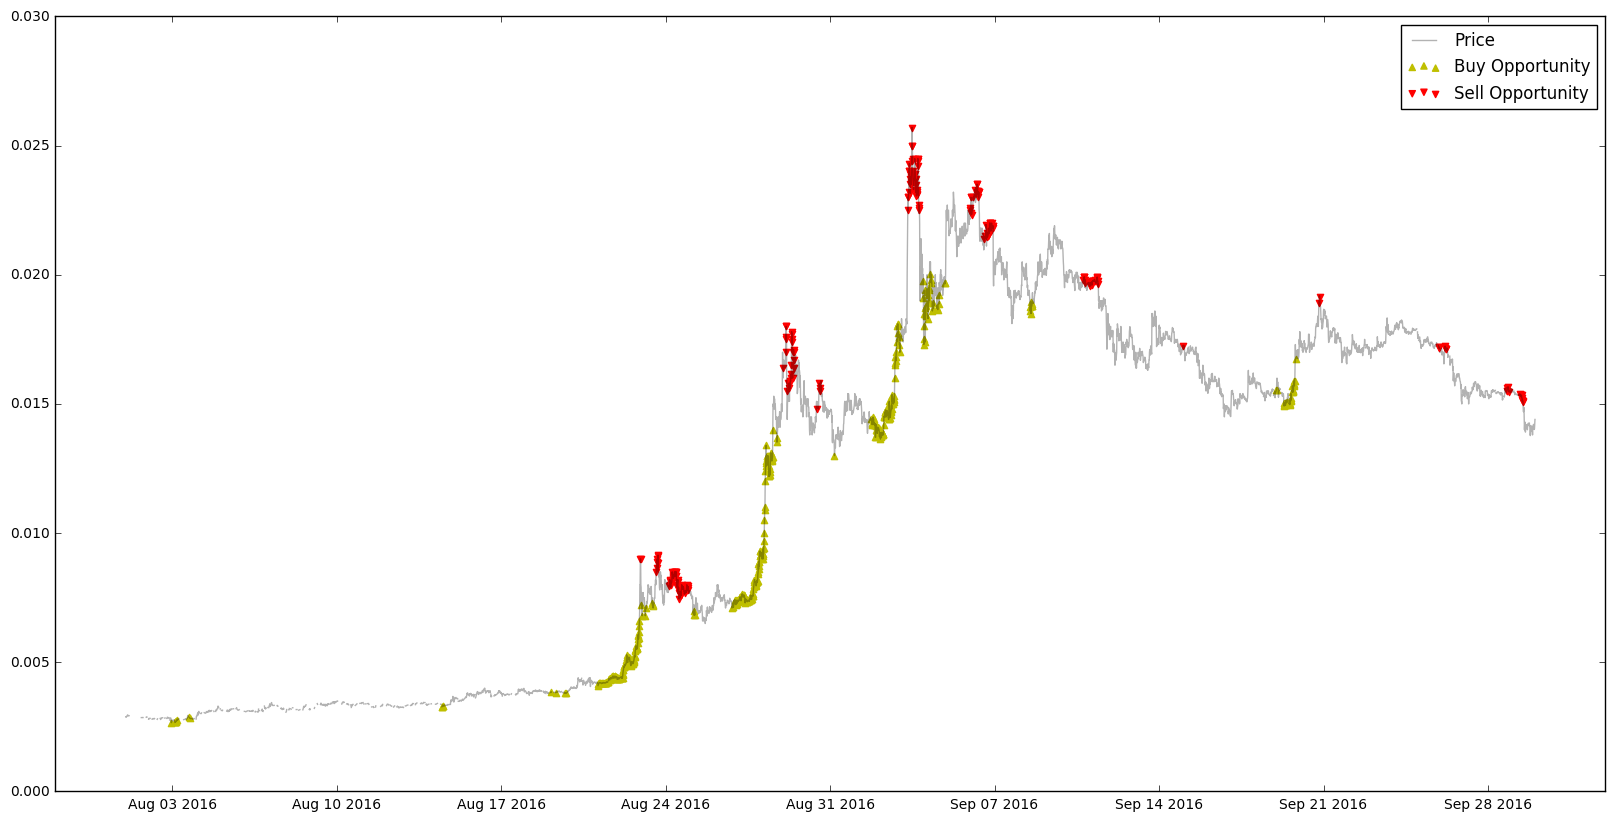

In [28]:
price_series = 'rate_value','buy','low','top'
plt.figure(figsize=(20,10))
plt.plot(full_df.index, full_df[price_series], color='black', alpha=0.3, label='Price')
plt.scatter(upward_spikes.index, upward_spikes[price_series], marker='^', color='y', label='Buy Opportunity')
plt.scatter(downward_spikes.index, downward_spikes[price_series], marker='v', color='r', label='Sell Opportunity')
plt.legend()
plt.show()

** Create a series for categorical labels **
* -1: sell opportunity
* 0: neutral
* 1: buy opportunity

In [174]:
def get_labels(period):
    if period['rate_pct_change','buy','low','top'] > 0.12:
        return 1
    if period['rate_pct_change','sell','low','top'] < -0.12:
        return -1
    else:
        return 0
              

labels = full_df.apply(get_labels, axis=1)
labels.name = 'label'
labels.value_counts()

 0    4524
 1     526
-1     244
Name: label, dtype: int64

### Reddit Data



In [129]:
from requests import get
from io import StringIO

xmr_reddit_comments = 'https://storage.googleapis.com/springboard-145615.appspot.com/reddit'
xmr_reddit_comments = StringIO(get(xmr_reddit_comments).content.decode('utf-8'))

comments = pd.read_csv(xmr_reddit_comments)[['body','created_utc','author']]
comments['created_utc'] = pd.to_datetime(comments.created_utc)
comments['time_interval'] = (comments.created_utc.astype(datetime)
                  .apply(lambda dt: time_interval(dt, timedelta(minutes=15))))
comments = comments.set_index('created_utc')
comments.head()

,body,author,time_interval
created_utc,,,
2016-06-14 08:38:57,"This is an idea, but a built in incentive to r...",skitalo,NaN
2016-06-08 08:28:39,&gt;ELI how it can be shipped with an ability ...,dEBRUYNE_1,NaN
2016-06-06 14:22:17,"Well, it was not intended to be stealth. It's ...",JollyMort,NaN
2016-06-08 14:23:34,Why?,Bagatell_,NaN
2016-06-10 20:13:38,It is a shame that people do not use forum.get...,communitytodolist,NaN


In [57]:
comments.shape

(31456, 2)

In [137]:
time_intervals = (comments.reset_index().created_utc.astype(datetime)
                  .apply(lambda dt: time_interval(dt, timedelta(minutes=15))))
time_intervals.index = comments.index
comments['time_interval'] = time_intervals
comments.head()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


,body,author,time_interval
created_utc,,,
2016-06-14 08:38:57,"This is an idea, but a built in incentive to r...",skitalo,2016-06-14 08:45:00
2016-06-08 08:28:39,&gt;ELI how it can be shipped with an ability ...,dEBRUYNE_1,2016-06-08 08:30:00
2016-06-06 14:22:17,"Well, it was not intended to be stealth. It's ...",JollyMort,2016-06-06 14:30:00
2016-06-08 14:23:34,Why?,Bagatell_,2016-06-08 14:30:00
2016-06-10 20:13:38,It is a shame that people do not use forum.get...,communitytodolist,2016-06-10 20:15:00


In [224]:
comments_at_first_spike = comments.reset_index().set_index('time_interval')['2016-08-16 00:00:00':'2016-08-28 00:00:00']
comments_at_first_spike.shape

(3479, 3)

In [233]:
def get_y(c):
    try:
        return labels.ix[c.name]
    except:
        return np.nan

In [235]:
y_labels = comments_at_first_spike.apply(get_y, axis=1)!=0
y_labels.value_counts()

False    2100
True     1379
dtype: int64

In [238]:
X_train, X_test, y_train, y_test = train_test_split(comments_at_first_spike.body.values, y_labels, 
                                                    test_size=0.33, random_state=42)

print("%d training examples (%d positive)" % (len(y_train), sum(y_train)))
print("%d test examples (%d positive)" % (len(y_test), sum(y_test)))

2330 training examples (895 positive)
1149 test examples (484 positive)



###  [Use LSA to vectorize the articles.](https://github.com/chrisjmccormick/LSA_Classification/blob/master/runClassification_LSA.py)

Tfidf vectorizer:
   - Strips out “stop words”
   - Filters out terms that occur in more than half of the docs (max_df=0.5)
   - Filters out terms that occur in only one document (min_df=2).
   - Selects the 10,000 most frequently occuring words in the corpus.
   - Normalizes the vector (L2 norm of 1.0) to normalize the effect of 
     document length on the tf-idf values. 

In [239]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', 
                             max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

Actual number of tfidf features: 6379


Project the tfidf vectors onto the first 150 principal components.
Though this is significantly fewer features than the original tfidf vector,
they are stronger features, and the accuracy is higher.

In [240]:
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 22%


In [242]:
# Now apply the transformations to the test data as well.
X_test_tfidf = vectorizer.transform(X_test)
X_test_lsa = lsa.transform(X_test_tfidf)

In [245]:
###############################################################################
#  Run classification of the test articles
###############################################################################

print("\nClassifying tfidf vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_tfidf = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_tfidf.fit(X_train_tfidf, y_train)

# Classify the test vectors.
p = knn_tfidf.predict(X_test_tfidf)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
print("  done in %.3fsec" % elapsed)


print("\nClassifying LSA vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_lsa = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_lsa.fit(X_train_lsa, y_train)

# Classify the test vectors.
p = knn_lsa.predict(X_test_lsa)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)    
print("    done in %.3fsec" % elapsed)


Classifying tfidf vectors...
  (656 / 1149) correct - 57.09%
  done in 0.132sec

Classifying LSA vectors...
  (626 / 1149) correct - 54.48%
    done in 0.135sec
